In [1]:
# ====================================
# Cell Prelim - prevent kernel crashes
# ====================================

import os

# 1. LIMIT THREADS TO P-CORES ONLY
# The i9-13900K has 8 Performance cores. 
# We set this to 8 to avoid HyperThreading overhead (safest) 
# or 16 to use P-core HyperThreading (might be faster, might be unstable).
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["TORCH_NUM_THREADS"] = "8"

# 2. OPTIONAL: INTEL SPECIFIC PINNING
# This forces the threads to stick to the physical cores and stop "swapping"
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"

In [2]:
# ===========================
# Cell 0 — Config (Monolith QAE, 6q_4l_2t, tau30)
# ===========================
import numpy as np
DATA_ID = 'mackey_glass_tau30_n200'

# Architecture (6q = 4 latent + 2 trash)
wind_size = 6
wind_step = 2
n_latent = 4
n_trash = wind_size - n_latent  # = 2
n_extra = 0

# Ansatz
rot = 'Rxyz'

# Training instances
LAYER_OPTIONS = [3]                   ### JC: Changed to timimg a single model of [2] layers, was [1,2,3,4,5]
INSTANCES_PER_LAYER = [1,2,3,4,5,6,7] ### JC: Retained all instances for timing testing (to allow median performance)

# Data parameters
noise = 0.2
split = 0.75
data_low = 0
data_high = 1

# Encoding/decoding ranges
y_margin = 0.0
y_enc_low, y_enc_high = 0 + y_margin, np.pi/4 - y_margin
y_dec_low, y_dec_high = 0 + y_margin, np.pi/4 - y_margin
noise_clip = True

# Simulator settings
sim = 'lightning.qubit'
interface = 'autograd'
diff_method = 'adjoint'
shots = None

# Training parameters
# - It is possible to pretrain the decoder and initialise the model with its weights
n_inv_decoder_epochs = [0] ### JC: In this version there is no pre-training of decoder
n_epochs = [300]           ### JC: Changed to epoch grid, was: 300 (previously best result)
lr_initial = 0.1
lr_decay_rate = 0.75
lr_decay_steps = 60
log_interv = 1
weight_scaler = 0.1
batch_size = 10

### JC: Created an epochs grid for timing testing
### JC: Combinations of encoder/decoder epochs for grid testing
epochs_grid = [(dec_epochs, enc_epochs) for enc_epochs in n_epochs for dec_epochs in n_inv_decoder_epochs]

# Seeds
TRAIN_SEED_BASE = 88000
TEST_SEED_FIXED = 99123

# Paths (relative to Monolith_QAE folder)
BUNDLE_ROOT = '../../qae_runs'

# Derived parameters
n_data = n_latent + n_trash
n_wires = n_latent + 2*n_trash + 2*n_extra

In [3]:
# ===========================
# Cell 1 — Imports & Utilities
# ===========================
import sys, os, time, random, json, csv
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint

# Add paths to find qae_utils
sys.path.append('../../..')
sys.path.append('../../../..')

# QAE utilities
from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg, ts_add_noise
from qae_utils.Charts import multi_plot_flat_ts, meas_plot
from qae_utils.Tools import draw_circuit

import pennylane as qml
from pennylane import numpy as pnp
import torch

# Create necessary folders
create_folder_if_needed(BUNDLE_ROOT)

np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (8, 4)

%matplotlib inline

def set_global_seed(instance_id: int, layer: int = None):
    """Set reproducible seeds for training instance"""
    if layer is not None:
        base = 10_000 + int(layer) * 1000 + int(instance_id)
    else:
        base = 10_000 + int(instance_id)
    
    random.seed(base + 11)
    np.random.seed(base + 22)
    try:
        pnp.random.seed(base + 33)
    except Exception:
        pass
    
    device_seed = base + 44
    
    return {
        'global_seed': base,
        'numpy_seed': base + 22,
        'pnp_seed': base + 33,
        'device_seed': device_seed
    }

def arch_tag():
    """Generate architecture tag string"""
    return f"{wind_size}q_{n_latent}l_{n_trash}t"

def x2y(x, xlim=(0, 1), ylim=(0, np.pi)):
    """Scale values from xlim range to ylim range"""
    low_x, high_x = xlim
    low_y, high_y = ylim
    input_range_length = high_x - low_x
    if np.isclose(input_range_length, 0.0):
        return (low_y + high_y) / 2
    scaling_factor = (high_y - low_y) / input_range_length
    return low_y + (x - low_x) * scaling_factor

✓ Found data at: /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/dev/data/mackey_glass_tau30_n200
Data folder: /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/dev/data/mackey_glass_tau30_n200
Loaded 200 samples; scale=[0.000, 1.000]


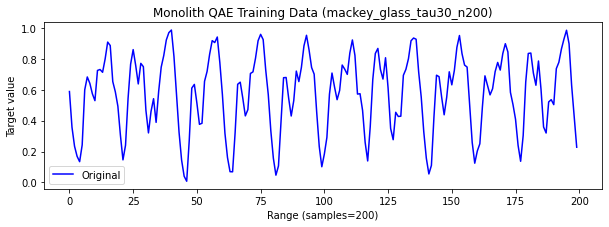

In [4]:
# ===========================
# Cell 2 — Load Data
# ===========================
def _find_data_folder(data_id):
    """Find data folder with robust path searching"""
    # Monolith notebooks: dev/Monolith_QAE/models/{dataset}/notebook.ipynb
    # Sidekick notebooks: dev/Sidekick_QAE/models/{dataset}/notebook.ipynb
    # Data location: dev/data/{dataset}/
    candidates = [
        f'../../../../data/{data_id}',  # Primary path (up 4 levels)
        f'../../../data/{data_id}',     # Alternative (up 3 levels)
        f'../../data/{data_id}',        # Alternative (up 2 levels)
    ]
    
    tried = []
    for folder in candidates:
        abs_path = os.path.abspath(folder)
        tried.append(abs_path)
        info_p = os.path.join(folder, 'info.json')
        x_p = os.path.join(folder, 'x_org.arr')
        y_p = os.path.join(folder, 'y_org.arr')
        
        if os.path.exists(info_p) and os.path.exists(x_p) and os.path.exists(y_p):
            print(f"✓ Found data at: {abs_path}")
            return folder
    
    raise FileNotFoundError(
        f"Could not find dataset: {data_id}\n"
        f"Tried paths:\n" + "\n".join(f"  - {p}" for p in tried)
    )

DATA_FOLDER = _find_data_folder(DATA_ID)
info = read_json_file(f'{DATA_FOLDER}/info.json')
X = read_ts_file(f'{DATA_FOLDER}/x_org.arr').astype(int)
y = read_ts_file(f'{DATA_FOLDER}/y_org.arr')

scale_low = float(info['scale_low'])
scale_high = float(info['scale_high'])

print(f'Data folder: {os.path.abspath(DATA_FOLDER)}')
print(f'Loaded {len(y)} samples; scale=[{scale_low:.3f}, {scale_high:.3f}]')

# Plot original data
multi_plot_flat_ts([X], [y], colors=['blue'], labels=['Original'],
                   lines=['solid'], legend_cols=1, rcParams=(10, 3),
                   xlabel=f'Range (samples={len(y)})',
                   title=f'Monolith QAE Training Data ({DATA_ID})')

In [5]:
# ===========================
# Cell 3 — Full QAE Architecture
# ===========================
def full_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Rxyz'):
    """Calculate weight shape for full QAE"""
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    elif rot == 'Rxyz':
        return qml.StronglyEntanglingLayers.shape(n_layers=n_layers*2, n_wires=n_wires)

def full_qae(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Rxyz', 
             add_outseq=False, invert_dec=True):
    """
    Create full QAE circuit with SWAP-based reset
    Returns: QNode-compatible callable
    """
    n_data = n_latent + n_trash
    n_anz = n_data + n_extra
    n_zero = n_trash + n_extra
    
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    extra_wires = wires[n_data:n_data+n_extra]
    zero_wires = wires[n_anz:n_anz+n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires + extra_wires

    def _sequence_encoder(wires, inputs):
        """Angle embedding of input sequence"""
        qml.AngleEmbedding(inputs, wires=wires, rotation='Y')

    def _entangler_shape(n_layers, n_wires, rot='Rxyz'):
        """Get shape for entangling layer"""
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

    def _entangler(wires, weights, rot='Rxyz'):
        """Apply entangling layers"""
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=wires)

    def _swap(from_wires, to_wires):
        """Apply SWAP gates"""
        for i in range(len(from_wires)):
            qml.SWAP(wires=[from_wires[i], to_wires[i]])

    def _full_qae(weights, inputs):
        """Full QAE circuit"""
        # Input encoding
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        # Get weight shapes
        enc_weights_shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        dec_weights_shape = enc_weights_shape

        # Split weights
        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        # Encoder
        _entangler(anz_wires, enc_weights, rot=rot)

        # SWAP reset
        qml.Barrier(wires)
        _swap(trash_wires + extra_wires, zero_wires)
        qml.Barrier(wires)

        # Decoder
        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        else:
            _entangler(anz_wires, enc_weights, rot=rot)
        qml.Barrier(wires)

        # Optional output sequence
        if add_outseq:
            qml.adjoint(_sequence_encoder)(data_wires, inputs)

        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]

    return _full_qae

shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers=1, rot=rot)
print(f'Base QAE shape (per layer): {shape}')
print(f'Architecture: {arch_tag()}')

Base QAE shape (per layer): (2, 6, 3)
Architecture: 6q_4l_2t


In [6]:
# ===========================
# Cell 4 — Training Functions
# ===========================
def get_mini_batches(W_noisy, W_clean, batch_size=10, shuffle=True, seed=0):
    """Generate mini-batches for training"""
    if seed == 0:
        seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    num_samples = W_clean.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        yield W_noisy[batch_indices], W_clean[batch_indices]

def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, 
                   range_low=0.2, range_high=0.8, seed=0, noise_clip=True):
    """Create sliding window tensors with optional noise"""
    y_noisy = ts_add_noise(y, noise=noise, noise_type='normal', clip=noise_clip,
                          range_low=range_low, range_high=range_high, seed=seed)
    y_ts = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = ts_wind_make(X, wind_size, wind_step)
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)
    
    X_train_tens = pnp.array(X_train_ts, requires_grad=False)
    y_train_tens = pnp.array(y_train_ts, requires_grad=False)
    X_test_tens = pnp.array(X_test_ts, requires_grad=False)
    y_test_tens = pnp.array(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

def mse_cost_on_tensors(targets, predictions):
    """MSE cost function (gradient-friendly)"""
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    return cost / vals

def cost_fun_gen_on_tensors(model, cost_fun):
    """Generate cost function for model"""
    def _cost_fun(params, inputs, targets):
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

### JC: Added calculation, accumulation and return of elapsed time at each log point (hist_times)
def train_with_noise(model, W, cost_fun, optimizer, n_epochs, init_weights=None,
                     log_interv=1, prompt_fract=0.1, start_time=0, seed=0,
                     wind_size=8, wind_step=4, noise=0, 
                     enc_lim=(0, 1), dec_lim=(0, 1)):
    """Train model with noisy mini-batches"""
    enc_low, enc_high = enc_lim
    dec_low, dec_high = dec_lim
    
    if seed == 0:
        seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    hist_cost = []
    hist_params = []
    hist_times = []
    params = init_weights.copy()
    
    # Prepare pure targets
    _, y_pure, _, _ = create_sw_tens(W, W, noise=0, wind_size=wind_size, 
                                     wind_step=wind_step, range_low=enc_low, 
                                     range_high=enc_high)
    y_pure = x2y(y_pure, xlim=(enc_low, enc_high), ylim=(dec_low, dec_high))
    
    if start_time == 0:
        start_time = time.time()
    
    for iter in range(n_epochs):
        # Generate noisy inputs
        _, X_noisy, _, _ = create_sw_tens(W, W, noise=noise, seed=seed+iter,
                                          noise_clip=noise_clip, wind_size=wind_size,
                                          wind_step=wind_step, range_low=enc_low,
                                          range_high=enc_high)
        
        # Decay learning rate
        if (iter+1) % lr_decay_steps == 0:
            optimizer.stepsize *= lr_decay_rate
        
        # Mini-batch training
        batches = get_mini_batches(X_noisy, y_pure, batch_size=batch_size, 
                                   shuffle=True, seed=seed+iter)
        acc_batch_cost = 0
        for batch_no, (noisy_batch, pure_batch) in enumerate(batches):
            params, batch_cost = optimizer.step_and_cost(
                lambda p: cost_fun(p, noisy_batch, pure_batch), params)
            acc_batch_cost += batch_cost
        cost = acc_batch_cost / (batch_no + 1)
        elapsed = int(time.time() - start_time) ### JC: Shifted to earlier point
        
        # Logging
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
            hist_times.append(elapsed)
        
        if (prompt_fract > 0) and (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({elapsed:04d} sec) cost={cost:0.6f}, ' +
                  f'min={np.min(hist_cost):0.6f} (LR={optimizer.stepsize:0.4f})')
    
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    elapsed = int(time.time() - start_time)
    print(f'\nCompleted: epochs={n_epochs}, min cost={min_cost:.6f} @ {min_iter}, ' +
          f'time={elapsed} sec\n')
    
    return hist_cost, hist_params, hist_times, init_weights, (min_iter, min_cost, elapsed)

In [7]:
# ===========================
# Cell 5 — Evaluation Functions
# ===========================
def _flatten_avg(windows):
    """Flatten overlapping windows by averaging"""
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def _mse(a, b):
    """Calculate MSE between two sequences"""
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

def windows_from_seed(y_vec, sigma, seed, clip=True):
    """Generate clean and noisy windows with fixed seed"""
    y_noisy = ts_add_noise(y_vec, noise=sigma, noise_type='normal', clip=clip,
                          range_low=scale_low, range_high=scale_high, seed=seed)
    win_clean = ts_wind_make(y_vec, wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return tr_clean, tr_noisy, te_clean, te_noisy

def run_qnode_series(model, params, windows):
    """Run model on series of windows"""
    outs = []
    for w in windows:
        z = model(params, w)
        outs.append(np.asarray(z))
    return np.stack(outs)

### JC: We will not be saving the circuits
def render_circuit(L, weights_vec, save_dir, inst, seed=None):
    """Render and save circuit diagram"""
    ### JC: Skipping all logic out
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    out_eps = save_dir / f"circuit_stage1_{arch_tag()}_L{L:02d}_inst{inst:02d}.eps"
    return out_eps

    wires = list(range(n_wires))
    qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=L, 
                   rot=rot, add_outseq=False, invert_dec=True)
    
    if seed is not None:
        dev = qml.device(sim, wires=n_wires, shots=shots, seed=seed)
    else:
        dev = qml.device(sim, wires=n_wires, shots=shots)
    
    qnode = qml.QNode(qae, dev)
    
    x_dummy = np.zeros(wind_size, dtype=float)
    qml.drawer.use_style("pennylane")
    fig_func = qml.draw_mpl(qnode, decimals=2, level="device")
    fig, ax = fig_func(weights_vec, x_dummy)
    ax.set_title(f'Monolith QAE (L={L}, inst={inst})')
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    out_eps = save_dir / f"circuit_{arch_tag()}_L{L}_inst{inst:02d}.eps"
    fig.savefig(out_eps, dpi=220, bbox_inches="tight", pad_inches=0.1, format="eps")
    plt.close(fig)
    return out_eps

In [8]:
# ===========================
# Cell 6 — Multi-Instance Training
# ===========================
import pandas as pd

def ensure_dir(p):
    """Create directory if it doesn't exist"""
    p = Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p

# Setup directory structure
ROOT = ensure_dir(BUNDLE_ROOT)
DATA_ROOT = ensure_dir(ROOT / DATA_ID)
ARCH_ROOT = ensure_dir(DATA_ROOT / arch_tag())
CSV_RUNS = ARCH_ROOT / "metrics_by_run.csv"
CSV_SUMMARY = ARCH_ROOT / "summary_by_layer.csv"

### JC: Added "dec_epochs", "enc_epochs", if decoder pre-training in use
RUNS_HEADER = [
    "dataset", "arch", 
    "dec_epochs", "enc_epochs",  ### JC: Added
    "instance_id", "layer",
    "window_size", "step", "sigma_eval",
    "mse_train_noise", "mse_train_recovered", "delta_train_pct",
    "mse_test_noise", "mse_test_recovered", "delta_test_pct",
    "min_train_cost", "training_time_sec", "timestamp", "bundle_json"
]

if not CSV_RUNS.exists():
    with open(CSV_RUNS, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow(RUNS_HEADER)

ALL_RUNS = []

### JC: Added an outer loop of decoder/encoder epoch combinations
for (dec_epochs, enc_epochs) in epochs_grid:
    print(f"\n{'='*60}")
    print(f"TRAINING with EPOCHS: dec={dec_epochs}, enc={enc_epochs}") ### JC: Added epochs
    print(f"{'='*60}")
    
    for L in LAYER_OPTIONS:
        print(f"\n{'='*60}")
        print(f"TRAINING LAYER {L} (EPOCHS: dec={dec_epochs}, enc={enc_epochs})") ### JC: Added epochs
        print(f"{'='*60}")
        
        # Get shape for this layer count
        shp = full_qae_shape(n_latent, n_trash, n_extra, n_layers=L, rot=rot)
        
        layer_dir = ensure_dir(ARCH_ROOT / f"L{L}")
        
        for inst in INSTANCES_PER_LAYER:
            print(f"\n{'─'*60}")
            print(f"Layer {L} | Instance {inst} (EPOCHS: dec={dec_epochs}, enc={enc_epochs})") ### JC: Added epochs
            print(f"{'─'*60}")
            
            # Set seed with layer parameter
            seed_info = set_global_seed(inst, layer=L)
            device_seed = seed_info['device_seed']
            print(f"Seeds: global={seed_info['global_seed']}, device={device_seed}")
    
            # Create device with seed
            wires = list(range(n_wires))
            dev = qml.device(sim, wires=n_wires, shots=shots, seed=device_seed)
            qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=L,
                           rot=rot, add_outseq=False, invert_dec=True)
            qae_model = qml.QNode(qae, dev, interface=interface, diff_method=diff_method)
            qae_model.shape = shp
            
            # Initialize optimizer and weights
            opt = qml.AdamOptimizer(stepsize=lr_initial, beta1=0.99)
            init_weights = pnp.array(np.random.uniform(high=2*np.pi, size=shp) * weight_scaler, 
                                     requires_grad=True)
            
            # Define cost function
            cost_fun = cost_fun_gen_on_tensors(qae_model, mse_cost_on_tensors)
            
            # Prepare encoded data
            y_enc = x2y(y, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
            
            ### JC: Added catching history of elapsed times
            ### JC: Training without decoder pre-training (future works)
            hist_cost, hist_params, hist_times, _, (min_iter, min_cost, elapsed) = train_with_noise(
                qae_model, y_enc, cost_fun, opt, enc_epochs, init_weights,
                log_interv=log_interv, prompt_fract=0.1, seed=TRAIN_SEED_BASE,
                wind_size=wind_size, wind_step=wind_step, noise=noise,
                enc_lim=(y_enc_low, y_enc_high), dec_lim=(y_dec_low, y_dec_high)
            )
            
            # Get optimal parameters
            opt_params = hist_params[min_iter]
            weights_np = np.array(opt_params)
            
            # Evaluate on test set
            tr_c, tr_n, te_c, te_n = windows_from_seed(y, noise, TEST_SEED_FIXED, clip=True)
            tr_n_enc = x2y(tr_n, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
            te_n_enc = x2y(te_n, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
            
            tr_hat = run_qnode_series(qae_model, opt_params, tr_n_enc)
            te_hat = run_qnode_series(qae_model, opt_params, te_n_enc)
            
            # Also evaluate from pure data
            tr_c_enc = x2y(tr_c, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
            te_c_enc = x2y(te_c, xlim=(scale_low, scale_high), ylim=(y_enc_low, y_enc_high))
            tr_hat_pure = run_qnode_series(qae_model, opt_params, tr_c_enc)
            te_hat_pure = run_qnode_series(qae_model, opt_params, te_c_enc)
            
            # Flatten all for metrics and plotting
            tr_pure = _flatten_avg(tr_c); te_pure = _flatten_avg(te_c)
            tr_noi = _flatten_avg(tr_n); te_noi = _flatten_avg(te_n)
            tr_rec = x2y(_flatten_avg(tr_hat), xlim=(y_dec_low, y_dec_high), 
                         ylim=(scale_low, scale_high))
            te_rec = x2y(_flatten_avg(te_hat), xlim=(y_dec_low, y_dec_high), 
                         ylim=(scale_low, scale_high))
            tr_rec_pure = x2y(_flatten_avg(tr_hat_pure), xlim=(y_dec_low, y_dec_high), 
                              ylim=(scale_low, scale_high))
            te_rec_pure = x2y(_flatten_avg(te_hat_pure), xlim=(y_dec_low, y_dec_high), 
                              ylim=(scale_low, scale_high))
            
            # Create coordinate arrays
            n_train = len(tr_pure)
            n_test = len(te_pure)
            X_coords_train = np.arange(0, n_train * wind_step, wind_step)[:n_train]
            X_coords_test = np.arange(n_train * wind_step, 
                                      n_train * wind_step + n_test * wind_step, 
                                      wind_step)[:n_test]
            
            # Calculate metrics
            mse_tr_noise = _mse(tr_pure, tr_noi)
            mse_te_noise = _mse(te_pure, te_noi)
            mse_tr_rec = _mse(tr_pure, tr_rec)
            mse_te_rec = _mse(te_pure, te_rec)
            mse_tr_rec_pure = _mse(tr_pure, tr_rec_pure)
            mse_te_rec_pure = _mse(te_pure, te_rec_pure)
            
            delta_tr = 100.0 * (1.0 - mse_tr_rec / max(mse_tr_noise, 1e-12))
            delta_te = 100.0 * (1.0 - mse_te_rec / max(mse_te_noise, 1e-12))
            
            print(f"Test MSE: noise={mse_te_noise:.6f}, recovered={mse_te_rec:.6f}, Δ={delta_te:+.2f}%")
            
            # Save artifacts
            inst_tag = f"inst{inst:02d}_L{L}"
            np.save(layer_dir / f"weights_{dec_epochs:03d}_enc{enc_epochs:03d}_{inst_tag}.npy", weights_np) ### JC: Changed file name
    
            # Pass device_seed to render function
            ### JC: We will not be saving the circuits for timing runs (dummy call)
            circuit_path = render_circuit(L, weights_np, ARCH_ROOT, inst, seed=device_seed)
            
            # Plot training cost
            cost_plot_path = layer_dir / f"training_cost_{dec_epochs:03d}_enc{enc_epochs:03d}_inst{inst_tag}.eps" ### JC: Changed file name
            meas_plot(hist_cost, meas='cost', task='min', 
                      title_pref=f'L{L} Instance Dec Epochs {dec_epochs:03d}, Enc Epochs {enc_epochs:03d} Inst {inst:02d} Stage 1 Training', ### JC: Changed title
                      ylim=(0, max(0.15, max(hist_cost)*1.1)), rcParams=(10, 4), 
                      log_interv=log_interv, backplot=True, back_color='lightgray', smooth_weight=0.5, 
                      # save_plot=cost_plot_path, show_plot=False) ### JC: Plots saved but not shown
                      save_plot=None, show_plot=False) ### JC: Plots not saved and not shown
            
            # Save cost and timing histories
            cost_path = layer_dir / f"cost_dec{dec_epochs:03d}_enc{enc_epochs:03d}_{inst_tag}.json" ### JC: Changed file name
            with open(cost_path, "w", encoding="utf-8") as f:
                json.dump([float(cost) for cost in hist_cost], f, indent=2)
            times_path = layer_dir / f"times_dec{dec_epochs:03d}_enc{enc_epochs:03d}_{inst_tag}.json" ### JC: Added file of elapsed times
            with open(times_path, "w") as f:
                json.dump([float(c) for c in hist_times], f, indent=2)
    
            # Plot reconstruction from pure data
            recon_pure_path = layer_dir / f"reconst_pure_dec{dec_epochs:03d}_enc{enc_epochs:03d}_{inst_tag}.eps" ### JC: Changed file name
            multi_plot_flat_ts(
                X_list=[X_coords_train, X_coords_test, X_coords_train, X_coords_test, X_coords_train, X_coords_test],
                y_list=[tr_noi, te_noi, tr_pure, te_pure, tr_rec_pure, te_rec_pure],
                labels=[f"Noisy train (MSE {mse_tr_noise:0.4f})", 
                        f"Noisy test  (MSE {mse_te_noise:0.4f})", 
                        "True train", "True test",
                        f"Recovered train (MSE {mse_tr_rec_pure:0.4f})", 
                        f"Recovered test  (MSE {mse_te_rec_pure:0.4f})"],
                vert_lines=['', 'dotted', '', '', '', ''], vert_line_color='gray',
                colors=['lightblue', 'pink', 'cornflowerblue', 'salmon', 'blue', 'red'],
                marker_colors=['white', 'white', 'lightblue', 'mistyrose', 'blue', 'red'],
                lines=['', '', 'solid', 'solid', 'dashed', 'dashed'],
                markers=['.', '.', '', '', '', ''],
                rcParams=(12, 6), dpi=200, legend_cols=3, 
                xlabel=f'Time (windows: size={wind_size}, step={wind_step})', ylabel='y Value', 
                title=f"Pure data vs recovered from pure data (L={L}, Dec Epochs={dec_epochs:03d}, Enc Epochs={enc_epochs:03d} Inst={inst:02d})", ### JC: Changed title
                # save_plot=recon_pure_path, show_plot=False) ### JC: Plots saved but not shown
                save_plot=None, show_plot=False) ### JC: Plots not saved and not shown
            
            # Plot reconstruction from noisy data
            recon_noisy_path = layer_dir / f"reconst_noisy_dec{dec_epochs:03d}_enc{enc_epochs:03d}_{inst_tag}.eps" ### JC: Changed file name
            multi_plot_flat_ts(
                X_list=[X_coords_train, X_coords_test, X_coords_train, X_coords_test, X_coords_train, X_coords_test],
                y_list=[tr_noi, te_noi, tr_pure, te_pure, tr_rec, te_rec],
                labels=[f"Noisy train (MSE {mse_tr_noise:0.4f})", 
                        f"Noisy test  (MSE {mse_te_noise:0.4f})", 
                        "True train", "True test",
                        f"Recovered train (MSE {mse_tr_rec:0.4f})", 
                        f"Recovered test  (MSE {mse_te_rec:0.4f})"],
                vert_lines=['', 'dotted', '', '', '', ''], vert_line_color='gray',
                colors=['lightblue', 'pink', 'cornflowerblue', 'salmon', 'blue', 'red'],
                marker_colors=['white', 'white', 'lightblue', 'mistyrose', 'blue', 'red'],
                lines=['', '', 'solid', 'solid', 'dashed', 'dashed'],
                markers=['.', '.', '', '', '', ''],
                rcParams=(12, 6), dpi=200, legend_cols=3, 
                xlabel=f'Time (windows: size={wind_size}, step={wind_step})', ylabel='y Value',
                title=f"Pure data vs recovered from noise (L={L}, Dec Epochs={dec_epochs:03d}, Enc Epochs={enc_epochs:03d} Inst={inst:02d})", ### JC: Changed title
                # save_plot=recon_noisy_path, show_plot=False) ### JC: Plots saved but not shown
                save_plot=None, show_plot=False) ### JC: Plots not saved and not shown
            
            # Create bundle
            bundle = {
                "schema": {"name": "monolith_qae_bundle", "version": "1.0"},
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
                "dataset": {
                    "id": DATA_ID,
                    "scale_low": float(scale_low),
                    "scale_high": float(scale_high),
                    "window_size": int(wind_size),
                    "window_step": int(wind_step),
                    "split": float(split),
                },
                "run": {
                    "instance_id": int(inst),
                    "layer": int(L),
                    "dec_epochs": dec_epochs, ### JC: Added
                    "enc_epochs": enc_epochs, ### JC: Added
                    "sigma_eval": float(noise),
                    "test_seed_fixed": int(TEST_SEED_FIXED),
                    "device_seed": int(device_seed),
                    "training_time_sec": int(elapsed),
                },
                "environment": {
                    "device": sim,
                    "diff_method": diff_method,
                    "interface": interface,
                },
                "architecture": {
                    "type": "monolith",
                    "n_qubits": int(wind_size),
                    "n_latent": int(n_latent),
                    "n_trash": int(n_trash),
                    "n_extra": int(n_extra),
                    "rot": str(rot),
                },
                "parameters": {
                    "weights": weights_np.tolist(),
                },
                "metrics": {
                    "mse_train_noise": float(mse_tr_noise),
                    "mse_train_recovered": float(mse_tr_rec),
                    "delta_train_pct": float(delta_tr),
                    "mse_test_noise": float(mse_te_noise),
                    "mse_test_recovered": float(mse_te_rec),
                    "delta_test_pct": float(delta_te),
                    "mse_train_recovered_pure": float(mse_tr_rec_pure),
                    "mse_test_recovered_pure": float(mse_te_rec_pure),
                    "min_train_cost": float(min_cost),
                },
                "artifacts": {
                    "weights_file": f"weights_{inst_tag}.npy",
                    "circuit_diagram": str(circuit_path.name),
                    "training_cost_plot": str(cost_plot_path.name),
                    "cost_history": str(cost_path.name),
                    "reconstruction_pure_plot": str(recon_pure_path.name),
                    "reconstruction_noisy_plot": str(recon_noisy_path.name),
                }
            }
            
            bundle_path = layer_dir / f"bundle_dec{dec_epochs:03d}_enc{enc_epochs:03d}_{inst_tag}.json" ### JC: Changed file name
            with open(bundle_path, "w", encoding="utf-8") as f:
                json.dump(bundle, f, indent=2)
            
            # Save to CSV
            ### JC: Added info on the training epochs
            row = [
                DATA_ID, arch_tag(), 
                dec_epochs, enc_epochs, ### JC: Added
                int(inst), int(L),
                int(wind_size), int(wind_step), float(noise),
                mse_tr_noise, mse_tr_rec, delta_tr,
                mse_te_noise, mse_te_rec, delta_te,
                float(min_cost), int(elapsed), bundle["timestamp"], str(bundle_path)
            ]
            
            if CSV_RUNS.exists():
                df_old = pd.read_csv(CSV_RUNS)
                df_new = pd.concat([df_old, pd.DataFrame([row], columns=RUNS_HEADER)], 
                                  ignore_index=True)
                df_new.to_csv(CSV_RUNS, index=False)
            else:
                pd.DataFrame([row], columns=RUNS_HEADER).to_csv(CSV_RUNS, index=False)
            
            ALL_RUNS.append({
                "dec_epochs": dec_epochs, ### JC: Included grid epochs
                "enc_epochs": enc_epochs, ### JC: Included grid epochs
                "instance_id": inst, 
                "layer": L, 
                "weights": weights_np
            })

print(f"\n{'='*60}")
print(f"TRAINING COMPLETE")
print(f"Metrics saved: {CSV_RUNS}")
print(f"Artifacts saved: {ARCH_ROOT}")
print(f"{'='*60}")


TRAINING COMPLETE
Metrics saved: ../../qae_runs/mackey_glass_tau30_n200/6q_4l_2t/metrics_by_run.csv
Artifacts saved: ../../qae_runs/mackey_glass_tau30_n200/6q_4l_2t


In [9]:
### JC: Separated for later changes
### JC: This summary is across all combinations of epochs and layers

# Generate summary
if CSV_RUNS.exists():
    df = pd.read_csv(CSV_RUNS)
    summary = (df.groupby(["dec_epochs", "enc_epochs", "layer"], as_index=True) ### JC: added grid info
               .agg(runs=("instance_id", "count"),
                    avg_training_time=("training_time_sec", "mean"),
                    mse_test_noise_mean=("mse_test_noise", "mean"),
                    mse_test_recovered_mean=("mse_test_recovered", "mean"),
                    delta_test_pct_mean=("delta_test_pct", "mean")))
    summary.to_csv(CSV_SUMMARY)
    print(f"\nSummary saved: {CSV_SUMMARY}")
    print(summary)


Summary saved: ../../qae_runs/mackey_glass_tau30_n200/6q_4l_2t/summary_by_layer.csv
                             runs  avg_training_time  mse_test_noise_mean  \
dec_epochs enc_epochs layer                                                 
0          300        3         7         237.571429             0.035742   

                             mse_test_recovered_mean  delta_test_pct_mean  
dec_epochs enc_epochs layer                                                
0          300        3                     0.014126             60.47679  


# Software in use (Linux)

In [10]:
import os
os.system('pip list | grep -e pennylane -e torch');

pennylane                 0.43.2
pennylane_lightning       0.43.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
